In [3]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev

In [4]:
def counted(f):
    def wrapped(*args, **kwargs):
        wrapped.calls += 1
        return f(*args, **kwargs)
    wrapped.calls = 0
    return wrapped

Проблемы: надо посчитать долю наследства
Для мигрантов матрицу размера 10к? (Каждое новое поколение имеет другое богатство)

In [13]:
class OLG_model:
    def __init__(self, G,T,N,epsilon, rho, sigma,Pi,r,price_M, price_E, tau_I,tau_II,tau_Ins, tau_pi, tau_VA, tau_rho, beta, phi , theta , psi, omega, alpha, delta, A,initial, eta,steady_max_iter,steady_guess):
        """
        OLG model
        :param G: number of generations, default is 110
        :param T: simulation time, default is 500
        :param N_female: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
        :param N_male: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
        :param epsilon_female: female cohort- and year-specific productivity
        :param epsilon_male: male cohort- and year-specific productivity
        :param rho_female: female cohort- and year-specific retirement rate
        :param rho_male: male cohort- and year-specific retirement rate
        :param sigma: pension rate (pension point value) as share of wage for T periods
        :param Pi_female: survival probability
        :param Pi_male: survival probability
        :param Beq_female_to_female,Beq_female_to_male,Beq_male_to_female,Beq_male_to_male: bequest matrix
        :param r: rate of return for T periods
        :param price_M: import prices for T periods
        :param price_E: export prices for T periods
        :param tau_I: income tax for T periods
        :param tau_II: income tax on investment for T periods
        :param tau_Ins: insurance tax for T periods
        :param tau_pi: profit tax for T periods
        :param tau_VA: value-added tax for T periods
        :param tau_rho: retirement tax for T periods
        :param beta: elasticity of intertemporal substitution
        :param phi: elasticity of intertemporal substitution
        :param theta: ?
        :param psi: ? investment cost
        :param omega: import share
        :param alpha: elasticity of capital
        :param delta: deprecation rate
        :param A_N: total factor productivity, non-export good
        :param A_E: total factor productivity, export goods
        """

        ## Exogenous variables and parameters
        # Demography
        self.G, self.T,self.N,self.epsilon,self.Pi = G, T,N,epsilon,Pi
        # Retirement
        self.rho, self.sigma = rho, sigma
        # Prices
        self.r, self.price_M, self.price_E, self.omega = r, price_M, price_E, omega
        # Taxation
        self.tau_I, self.tau_II, self.tau_pi, self.tau_VA,self.tau_Ins, self.tau_rho =  tau_I,tau_II, tau_pi,tau_VA,tau_Ins, tau_rho
        # Utility
        self.beta, self.phi, self.theta  = beta, phi, theta
        # Production
        self.psi, self.alpha, self.delta, self.A = psi, alpha, delta, A

        self.a_initial = initial["a"]



        self.eta = eta
        self.steady_max_iter = steady_max_iter

        # Endogenous variable
        # Initial guess
        self.price_N = np.array([initial["price_N"] for _ in range(max_time)])
        self.K = np.array([[initial["K_N"] for _ in range(max_time)], [initial["K_E"] for _ in range(max_time)]])
        self.L = np.array([[initial["L_N"] for _ in range(max_time)], [initial["L_E"] for _ in range(max_time)]])
        self.I = np.array([[initial["I_N"] for _ in range(max_time)], [initial["I_E"] for _ in range(max_time)]])
        
        self.Debt = np.array([initial["Debt"] for _ in range(max_time)])
        
        
        self.VA_sum= np.zeros_like(self.Debt)
        self.I_sum= np.zeros_like(self.Debt)
        self.II_sum= np.zeros_like(self.Debt)
        
        self.Ins_sum= np.zeros_like(self.Debt)
        self.Rho_sum= np.zeros_like(self.Debt)
        self.Pi_sum= np.zeros_like(self.Debt)
            
        self.Gov_Income= np.zeros_like(self.Debt)
        
        self.Gov_Outcome= np.zeros_like(self.Debt)
        self.Deficit= np.zeros_like(self.Debt)
        self.Deficit_ratio= np.zeros_like(self.Debt)

        self.lmbda = np.array([[0.5 for _ in range(max_time)] for _ in range(2)])

        self.w = ((self.price_N *(1-self.alpha)*(self.K[0])**self.alpha *(self.A[0])**(1-self.alpha)*(self.L[0])**(-self.alpha))+
        (self.price_E *(1-self.alpha)*(self.K[1])**self.alpha *(self.A[1])**(1-self.alpha)*(self.L[1])**(-self.alpha)))/2

        self.price = (self.price_M)**self.omega * (self.price_N)**(1-self.omega)


        self.Y = self.K**self.alpha * (self.L*self.A)**(1-self.alpha)

        
        self.k = np.zeros_like(self.K)
        self.k[0] = self.K[0]/((self.L[0]+self.L[1])*self.A[0])
        self.k[1] = self.K[1]/((self.L[0]+self.L[1])*self.A[1])
        
        self.i = self.I/self.K
        
        self.lmbda_to_price = np.zeros_like(self.lmbda)
        
        self.lmbda_to_price[0] = self.lmbda[0]/self.price
        self.lmbda_to_price[1] = self.lmbda[1]/self.price
        
        self.L_share = np.zeros_like(self.L)
        self.L_share[0] = self.L[0]/(self.L[0]+self.L[1])
        self.L_share[1] = self.L[1]/(self.L[0]+self.L[1])
        


        self.c =  np.array([[[0.002 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
        self.a = np.array([[[0.01 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
        self.gamma = np.array([[[0.9 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
        self.l = np.array([[[0.4 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])

        Consumption = np.array([np.sum([self.c[s,g,t]*self.N[s,g,t] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
        self.Consumption = Consumption

        Labor = np.array([np.sum([self.l[s,g,self.T]*self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
        self.Labor = Labor

        Assets =  np.array([np.sum([self.a[s,g,t]*self.N[s,g,t] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
        self.Assets = Assets

        
        self.steady = np.array(list(steady_guess) + [Consumption[self.T], Labor[self.T], Assets[self.T]])
        self.steady_path = []
        
        self.A_growth = self.A[0,self.T]/self.A[0, self.T-1]
        self.N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
                   np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])
        

        self.lmbda_to_price_steady = (1+self.tau_VA[self.T])/((1 - self.psi/2 * (self.A_growth*self.N_growth -1)**2 - self.psi*self.A_growth*self.N_growth * (self.A_growth*self.N_growth -1))+self.psi/(1+self.r[self.T+1]) * (self.A_growth*self.N_growth -1)* (self.A_growth*self.N_growth)**2)
        self.i_steady  = (self.A_growth*self.N_growth-1+self.delta) / (1-self.psi/2*(self.A_growth*self.N_growth -1)**2)
        
        self.D = self.Consumption+self.I[0]+self.I[1]
        
        self.M = self.omega * self.D * self.price / self.price_M
        
        self.Gov = np.array([initial["Gov"]*(self.A_growth*self.N_growth)**i  for i in range(max_time)])

        self.GDP = self.D+ self.price_N/self.price * self.Gov
          
    def update_government(self, t):
        self.VA_sum[t] = self.tau_VA[t]*self.price[t]*(self.Consumption[t]+self.I[0,t]+self.I[1, t])
        self.II_sum[t] = self.tau_II[t]*self.Assets[t]
        self.I_sum[t] = self.Labor[t] * self.w[t] *\
                        (1-(self.tau_rho[t] + self.tau_Ins[t])/\
                         (1+self.tau_rho[t] + self.tau_Ins[t])) *\
                        self.tau_I[t] 
        
        
        
        self.Ins_sum[t] = self.tau_Ins[t]/(1+self.tau_rho[t] + self.tau_Ins[t]) * self.Labor[t] * self.w[t]
        self.Rho_sum[t] = self.tau_rho[t]/(1+self.tau_rho[t] + self.tau_Ins[t]) * self.Labor[t] * self.w[t]
        self.Pi_sum[t] = self.tau_pi[t] * (self.price[t] * self.K[0,t]**self.alpha *\
                                           (self.L[0,t]*self.A[0,t])**(1-self.alpha) -\
        self.w[t]*self.L[0,t] - self.delta * self.price[t]*self.K[0,t])+\
            self.tau_pi[t] * (self.price[t] * self.K[1,t]**self.alpha *\
                                           (self.L[1,t]*self.A[1,t])**(1-self.alpha) -\
            self.w[t]*self.L[1,t] - self.delta * self.price[t]*self.K[1,t])
            
        self.Gov_Income[t] = self.VA_sum[t] + self.I_sum[t]+self.II_sum[t]+self.Ins_sum[t]+self.Rho_sum[t]+self.Pi_sum[t]
        
        self.Gov_Outcome[t] = self.Gov[t] + self.sigma[t]*self.w[t] * np.sum(self.rho[:,:,t]*self.N[:,:,t])+\
                self.r[t]*self.Debt[t-1]
        self.Deficit[t] = self.Gov_Outcome[t] - self.Gov_Income[t]
        self.Deficit_ratio[t] = self.Deficit[t]/(self.Consumption[t]+np.sum(self.I[:,t])+self.Gov[t])
        self.Debt[t] = self.Debt[t-1]+self.Deficit[t]
        


    def household(self, s, g, t):
        def labor_income_vector(self, s, g, start, end):
            return (1-self.tau_I[start:end]) * (1-(self.tau_rho[start:end] + self.tau_Ins[start:end])/(1+self.tau_rho[start:end] + self.tau_Ins[start:end])) * self.epsilon[s,g,start:end] * self.w[start:end]
        def cumulative_rate_of_return(self,start, end):
            if start <= end:
                return np.prod(1+self.r[start:end]*(1-self.tau_II[start:end]))
            else:
                return 1

        def get_initial_consumption(self, s, g, t_0):
            return self.phi * (self.a_initial[s,g] * cumulative_rate_of_return(self, t_0, g+1)+
                               np.sum(np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
                                      (labor_income_vector(self, s, g, t_0, g+1)+self.rho[s,g,t_0:(g+1)]*self.sigma[t_0:(g+1)]*self.w[t_0:(g+1)]
                                       )))/\
                   np.sum(
                       np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
                       (1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])*
                       (
                               np.array([cumulative_rate_of_return(self,t_0+1, end) for end in range(t_0+1, g+2)])*
                               self.beta**np.array([i-t_0 for i in range(t_0, g+1)])*self.Pi[s,g,t_0:(g+1)]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*(self.price[t_0])/((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])) *
                               ((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])/((1+self.tau_VA[t_0])*self.price[t_0])*labor_income_vector(self, s, g,t_0, t_0+1)/labor_income_vector(self, s, g,t_0, g+1)
                                )**((1-self.phi)*(1-self.theta)))**(1/self.theta)
                   )
        t_0 = max(g-self.G+1,0)
        bequest = 0
        if t==t_0:
            consumption = get_initial_consumption(self, s, g, t_0)
        elif t_0 < t <= g:
            consumption = self.c[s, g, t_0]*\
                          (cumulative_rate_of_return(self, t_0+1, t+1)*
                           self.beta**(t-t_0)*self.Pi[s,g,t]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*self.price[t_0]/((1+self.tau_VA[t])*self.price[t]) *
                           ((1+self.tau_VA[t])*self.price[t]/((1+self.tau_VA[t_0])*self.price[t_0])*labor_income_vector(self, s, g,t_0, t_0+1)/labor_income_vector(self, s, g,t, t+1))**((1-self.phi)*(1-self.theta))
                           )**(1/self.theta)


        labor = 1- consumption/(self.phi/(1-self.phi)*(1/((1+self.tau_VA[t])*self.price[t]))*labor_income_vector(self, s, g, t, t+1)[0])
        if t == 0:
            assets = labor_income_vector(self, s, g, t, t+1)[0]*labor+self.rho[s,g,t]*self.sigma[t]*self.w[t] - consumption*(1+self.tau_VA[t])*self.price[t]+self.a_initial[s,g]*(1+self.r[t]*(1-self.tau_II[t]))
        else:
            assets = labor_income_vector(self, s, g, t, t+1)[0]*labor+self.rho[s,g,t]*self.sigma[t]*self.w[t] - consumption*(1+self.tau_VA[t])*self.price[t]+(self.a[s,g, t-1]+bequest)*(1+self.r[t]*(1-self.tau_I[t]))
        return consumption, labor, assets

    @counted
    def steady_state(self):
        def labor_income_vector(self, s, g, start, end):
            return (1-self.tau_I[start:end]) * (1-(self.tau_rho[start:end] + self.tau_Ins[start:end])/(1+self.tau_rho[start:end] + self.tau_Ins[start:end])) * self.epsilon[s,g,start:end] * self.w[start:end]

        w_steady, price_steady, price_N_steady = self.steady[6:9]

        for t in range(self.T-self.G + 1, max_time):
            self.w[t] = w_steady* self.A_growth**(t - self.T)
            self.price[t] = price_steady
            self.price_N[t] = price_N_steady

        for s in range(2):
            initial_household = self.household(s, self.G+self.T-1, self.T) # первое родившееся поколение в период self.T
            self.c[s, self.G+self.T-1, self.T],self.l[s, self.G+self.T-1,self.T],self.a[s, self.G+self.T-1,self.T] = initial_household
            for t in range(self.T,self.G+self.T):
                self.c[s, self.G+self.T-1, t],self.l[s, self.G+self.T-1,t],self.a[s, self.G+self.T-1,t] = self.household(s, self.G+self.T-1, t)
            for g in range(self.G+self.T-2, self.T-1, -1): # все поколения, живущие в периоде self.T

                self.c[s, g, g-self.G + 1]  = initial_household[0] * self.A_growth**(self.G+self.T-1 - g)
                self.l[s, g, g-self.G + 1]  = initial_household[1]
                self.a[s, g,g-self.G + 1]  = labor_income_vector(self, s, g,g-self.G + 1, g-self.G + 2)[0]*self.l[s, g, g-self.G + 1]+self.rho[s,g,g-self.G + 1]*self.w[g-self.G + 1]*self.sigma[g-self.G + 1] - self.c[s, g, g-self.G + 1]*(1+self.tau_VA[g-self.G + 1])*self.price[g-self.G + 1]
                for t in range(g-self.G + 2, g+1):
                    self.c[s, g, t],self.l[s, g, t],self.a[s, g, t] =  self.household(s, g, t)
        Consumption = np.sum([self.c[s,g,self.T]*self.N[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

        Labor = np.sum([self.l[s,g,self.T]*self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

        Assets =  np.sum([self.a[s,g,self.T]*self.N[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

        if len(self.steady_path)==0:
            self.steady[-3:] = np.array([Consumption,  Labor, Assets])
        else:
            self.steady[-3:] = self.eta*np.array([Consumption,  Labor, Assets]) + (1-self.eta)*self.steady[-3:]

        z_guess = self.steady[:6]
        
        def equilibrium(z, self=self, objective = True):


  
            system = [
                f"{1-self.alpha}*price_N_steady * (k_N_steady/L_N_share)**{self.alpha} *{self.A[0,self.T]} - w_steady"
                      ,f"{1/(1+self.r[self.T+1])}*(({1-self.tau_pi[self.T+1]}) *{self.alpha}*price_N_steady* (k_N_steady/L_N_share)**{self.alpha-1} +{self.tau_pi[self.T+1]} * {self.delta} + {self.lmbda_to_price_steady}*price_steady * ({1-self.delta})) - {self.lmbda_to_price_steady}*price_steady"
                      ,f"{1-self.alpha}*{self.price_E[self.T]} * (k_E_steady/(1-L_N_share)*{self.A[0,self.T]/self.A[1,self.T]} )**{self.alpha} *{self.A[1,self.T]} - w_steady"
                      ,f"{1/(1+self.r[self.T+1])}*({1-self.tau_pi[self.T+1]}*{self.alpha}* {self.price_E[self.T+1]}* (k_E_steady/(1-L_N_share)*{self.A[0,self.T]/self.A[1,self.T]})**{self.alpha-1} +{self.tau_pi[self.T+1]} * {self.delta} +{self.lmbda_to_price_steady}*price_steady * {1-self.delta}) - {self.lmbda_to_price_steady}*price_steady"
                      ,f"price_N_steady*((k_N_steady/L_N_share)**{self.alpha} * L_N_share -{self.Gov[self.T]/(self.A[0,self.T]*self.steady[-2])})- (1-{self.omega}) * price_steady * ({self.steady[-3]/(self.A[0,self.T]*self.steady[-2])}+{self.i_steady}*(k_N_steady+k_E_steady))"
                      ,f"price_steady - {self.price_M[self.T]**self.omega}*price_N_steady**({1-self.omega})"
                      ]
            name_space = {label:value for label, value in zip(("self", "k_N_steady", "L_N_share",
                                                               "k_E_steady", "w_steady",
                                                               "price_steady", "price_N_steady"),[self]+list(z))}

            if objective:
                sum_of_squares = "+".join([f"({equation})**2" for equation in system])
                F = eval(sum_of_squares,{},name_space)
            else:
                F = [eval(equation,{},name_space) for equation in system]
            return F
        def equilibrium_gradient(z, self=self, objective = True):

            self.A_growth = self.A[0,self.T]/self.A[0, self.T-1]
            self.N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
                       np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])

            name_space = {label:value for label, value in zip(("self","I_N_steady", "K_N_steady", "L_N_steady","I_E_steady", "K_E_steady", "lmbda_steady", "w_steady", "price_steady", "price_N_steady"),[self]+list(z))}
            if objective:
                target_system = equilibrium(z, self, False)
                sum_of_gradient = ["+".join([f"2*({outer})*({inner})" for outer, inner in zip(target_system, row)]) for row in gradient]
                J = [eval(equation,{},name_space) for equation in sum_of_gradient]
            else:
                J = [[eval(equation,{},name_space) for equation in row] for row in gradient]
            return J
            

        
        obj_jit = jit(equilibrium)
        obj_grad = jit(jacfwd(obj_jit))
        obj_hess = jit(jacrev(jacfwd(obj_jit)))
        
        
        result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
                                , options = {"max_iter":self.steady_max_iter, "print_level":0,
                                             "check_derivatives_for_naninf":"yes"}
                                , tol=1e-7)
        
        
        if result["success"] or result["status"]==1:
            self.steady[:6] = self.eta*result["x"] + (1-self.eta)*z_guess
            self.steady_max_iter = 1000
            eq_res = equilibrium(self.steady[:6], self, False)
        else:
            if result["status"]==-1:
                self.steady_max_iter += 1000
            self.steady[:6] = z_guess
            eq_res = equilibrium(z_guess, self, False)
            
                
        self.steady_path.append((result, np.array(self.steady)
                               ))

    def create_guess(self):
        
        k_N_steady, L_N_share, k_E_steady, w_steady, price_steady, price_N_steady, Consumption_steady, Labor_steady, Assets_steady = self.steady
        
        steady_start = self.T-self.G + 1
        
        for t in range(steady_start, max_time):
            self.update_government(t)
            
            self.w[t] = w_steady* self.A_growth**(t - self.T)
            self.price[t] = price_steady
            self.price_N[t] = price_N_steady
            
            self.k[0,t] = k_N_steady
            self.k[1,t] = k_E_steady
            
            self.i[0,t] = self.i_steady
            self.i[1,t] = self.i_steady 
            
            self.L_share[0,t] = L_N_share 
            self.L_share[1,t] = 1- L_N_share 
            
            self.lmbda_to_price[0,t] = self.lmbda_to_price_steady
            self.lmbda_to_price[1,t] = self.lmbda_to_price_steady
            
            
            
            self.K[0,t] = k_N_steady* Labor_steady * self.A[0,self.T] *(self.A_growth*self.N_growth)**(t - self.T)
            self.K[1,t] = k_E_steady* Labor_steady * self.A[0,self.T] *(self.A_growth*self.N_growth)**(t - self.T)
            
            self.I[0,t] = self.i_steady * self.K[0,t]
            self.I[1,t] = self.i_steady * self.K[1,t]
            
            self.L[0,t] = L_N_share * Labor_steady *(self.N_growth)**(t - self.T)
            self.L[1,t] = (1-L_N_share) * Labor_steady *(self.N_growth)**(t - self.T)
            
            self.lmbda[0,t] = self.lmbda_to_price_steady * price_steady
            self.lmbda[1,t] = self.lmbda_to_price_steady * price_steady
            
            self.Consumption[t] = Consumption_steady*(self.A_growth*self.N_growth)**(t - self.T)
            self.Labor[t] = Labor_steady*(self.N_growth)**(t - self.T)
            self.Assets[t] =  Assets_steady*(self.A_growth*self.N_growth)**(t - self.T)


        
        self.price_N[:steady_start] = np.linspace(initial["price_N"], self.price_N[steady_start], steady_start,endpoint=False)
        self.I[0,:steady_start] = np.linspace(initial["I_N"], self.I[0,steady_start], steady_start,endpoint=False)
        self.K[0,:steady_start] = np.linspace(initial["K_N"], self.K[0,steady_start], steady_start,endpoint=False)
        self.L[0,:steady_start] = np.linspace(initial["L_N"], self.L[0,steady_start], steady_start,endpoint=False)

        self.I[1,:steady_start] = np.linspace(initial["I_E"], self.I[1,steady_start], steady_start,endpoint=False)
        self.K[1,:steady_start] = np.linspace(initial["K_E"], self.K[1,steady_start], steady_start,endpoint=False)
        self.L[1,:steady_start] = np.linspace(initial["L_E"], self.L[1,steady_start], steady_start,endpoint=False)

        w_initial = self.price_N[0] *(1-self.alpha)*(self.K[0,0])**self.alpha *(self.A[0,0])**(1-self.alpha)
        self.w[:steady_start] = np.linspace(w_initial, self.w[steady_start], steady_start,endpoint=False)

        self.Labor[:steady_start] = np.linspace(initial["L_N"]+initial["L_E"],
                                    self.Labor[steady_start], steady_start,endpoint=False)
        
        self.price[:steady_start] = (self.price_M[:steady_start])**self.omega * (self.price_N[:steady_start])**(1-self.omega)
        
        self.lmbda[0,:steady_start] = self.price[:steady_start]*self.lmbda_to_price_steady
        self.lmbda[1,:steady_start] = self.price[:steady_start]*self.lmbda_to_price_steady
        
        self.k[0,:steady_start] = self.K[0,:steady_start]/(self.A[0,:steady_start]*self.Labor[:steady_start])
        self.k[1,:steady_start] = self.K[1,:steady_start]/(self.A[0,:steady_start]*self.Labor[:steady_start])
            
        self.i[:steady_start] = self.I[:steady_start]/self.K[:steady_start]
            
        self.L_share[0,:steady_start] = self.L[0,:steady_start]/self.Labor[:steady_start]
        self.L_share[1,:steady_start] = self.L[1,:steady_start]/self.Labor[:steady_start]
            
        self.lmbda_to_price[0,:steady_start] = self.lmbda_to_price_steady
        self.lmbda_to_price[1,:steady_start] = self.lmbda_to_price_steady
        
            
        
        

    def update_guess(self):

        for t in range(1, self.T-self.G + 1):
            self.update_government(t)
        # Households (analytical solution)
        for s in range(2):
            for t in range(self.T-self.G + 1):
                for g in range(t, self.G+t):
                    self.c[s, g, t],self.l[s, g, t],self.a[s, g, t]  = self.household(s,g,t)
                    
                    self.Consumption[t] = np.sum([self.c[s,g,t]*self.N[s,g,t] for g in range(t, self.G+t) for s in range(2)])
                    self.Labor[t] = np.sum([self.l[s,g,t]*self.N[s,g,t]*self.epsilon[s,g,t] for g in range(t, self.G+t) for s in range(2)])
                    self.Assets[t] =  np.sum([self.a[s,g,t]*self.N[s,g,t] for g in range(t, self.G+t) for s in range(2)])

        for t in range(1, self.T-self.G + 1):
            z_guess = np.array([self.i[0,t],self.k[0,t+1],self.L_share[0,t],
                       self.lmbda_to_price[0,t], self.i[1,t],self.k[1,t+1],
                       self.lmbda_to_price[1,t],
                       self.w[t], self.price_N[t], self.price[t]])


            def equilibrium(z, self=self, t = t):
                i_N, k_N, L_N_share, lmbda_N_to_price,\
                    i_E, k_E, lmbda_E_to_price,\
                    w, price, price_N = z
                system =(
                  price_N * self.A[0, t] * (self.k[0, t]/L_N_share)**self.alpha - w\
                )**2+\
                ( (1+tau_VA[t])*price - lmbda_N_to_price * price* (1-self.psi/2 *(i_N/self.i[0,t-1]*self.K[0,t]/self.K[0, t-1] - 1)**2\
                   - self.psi * (i_N/self.i[0,t-1]*self.K[0,t]/self.K[0, t-1]) * \
                                          (i_N/self.i[0,t-1]*self.K[0,t]/self.K[0, t-1] - 1) )-\
                   self.lmbda_to_price[0,t+1]*self.price[t+1]*self.psi/(1+self.r[t+1]) *\
                   (self.i[0,t+1]/i_N*k_N*self.A[0, t+1]*self.Labor[t+1]/self.K[0,t] )**2 *\
                (self.i[0,t+1]/i_N*k_N*self.A[0, t+1]*self.Labor[t+1]/self.K[0,t] -1)
                )**2+\
                ( 1/(self.r[t+1]) * ((1-self.tau_pi[t+1]) * self.alpha * self.price_N[t+1] *\
                                              (k_N/L_N_share)**(self.alpha-1) +\
                                              self.tau_pi[t+1] * self.delta * self.price[t+1] +\
                                              self.lmbda_to_price[0, t+1]*self.price[t+1] * (1-self.delta) ) -\
                lmbda_N_to_price * price\
                )**2+\
                ( (1-self.delta)+\
                           i_N * (1-self.psi / 2 *(i_N/self.i[0,t-1]*self.K[0,t]/self.K[0, t-1] - 1)**2 ) -\
                k_N*self.A[0, t+1]*self.Labor[t+1]/self.K[0,t]\
                )**2+\
                (
                self.price_E[t] * self.A[1, t] * (self.k[1, t]/(1-L_N_share)*self.A[0,t]/self.A[1,t])**self.alpha - w
                )**2+\
                ( (1+tau_VA[t])*price - lmbda_E_to_price*price * (1-self.psi/2 *(i_E/self.i[1,t-1]*self.K[1,t]/self.K[1, t-1] - 1)**2\
                   - self.psi * (i_E/self.i[1,t-1]*self.K[1,t]/self.K[1, t-1]) * \
                                          (i_E/self.i[1,t-1]*self.K[1,t]/self.K[1, t-1] - 1) )-\
                   self.lmbda_to_price[1,t+1]*self.price[t+1]*self.psi/(1+self.r[t+1]) *\
                   (self.i[1,t+1]/i_E*k_E*self.A[1, t+1]*self.Labor[t+1]/self.K[1,t] )**2 *\
                (self.i[1,t+1]/i_E*k_E*self.A[1, t+1]*self.Labor[t+1]/self.K[1,t] -1)
                )**2+\
                ( 1/(self.r[t+1]) * ((1-self.tau_pi[t+1]) * self.alpha * self.price_E[t+1] *\
                                              (k_E/(1-L_N_share)*self.A[0,t]/self.A[1,t])**(self.alpha-1) +\
                                              self.tau_pi[t+1] * self.delta * self.price[t+1] +\
                                              self.lmbda_to_price[1, t+1]*self.price[t+1] * (1-self.delta) ) -\
                lmbda_E_to_price * price\
                )**2+\
                ((1-self.delta)+\
                           i_E * (1-self.psi / 2 *(i_E/self.i[1,t-1]*self.K[1,t]/self.K[1, t-1] - 1)**2 ) -\
                k_E*self.A[1, t+1]*self.Labor[t+1]/self.K[1,t]
                )**2+\
                ( price - (self.price_M[t])**self.omega * (price_N)**(1-self.omega)\
                )**2+\
                ( self.k[0,t]**self.alpha *\
                - self.Gov[t]/(self.A[0,t]*self.Labor[t]) - \
                (1-self.omega) * price / price_N * \
                (self.Consumption[t]/(self.A[0,t]*self.Labor[t]) +\
                i_N*k_N/L_N_share + i_E*k_E/(1-L_N_share))
                 )**2
            
                return system
  

            
            obj_jit = jit(equilibrium)
            obj_grad = jit(jacfwd(obj_jit))
            obj_hess = jit(jacrev(jacfwd(obj_jit)))
        
        
            result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
                                , options = {"max_iter":self.steady_max_iter, "print_level":0,
                                             "check_derivatives_for_naninf":"yes"}
                                , tol=1e-5)
            z = result["x"]
            if result["success"]:
                self.i[0,t],self.k[0,t+1],self.L_share[0,t],\
                self.lmbda_to_price[0,t], self.i[1,t],self.k[1,t+1],\
                self.lmbda_to_price[1,t],\
                self.w[t], self.price_N[t], self.price[t] = self.eta*z+(1-self.eta)*z_guess
                self.L_share[1,t] = 1- self.L_share[0,t]
            
            # Market clearing (analytical solution)
#             self.Y = self.K**self.alpha * (self.L*self.A)**(1-self.alpha)
#             self.D = self.I.sum(axis = 0)+(self.N[:,:self.c.shape[1],:]*self.c[:,:self.c.shape[1],:]).sum(axis=0).sum(axis =0)
#             self.M =  self.omega * self.D * self.price / self.price_M


In [14]:
# import pyreadr
# import numpy as np
# demography = {name:np.array(pyreadr.read_r(f"{name}.Rda")[name]) for name in ["Pi_female", "Pi_female_steady", "Pi_male", "Pi_male_steady","N_female", "N_male","N_female_steady","N_male_steady"]}
# np.save('demography.npy', demography)

In [15]:
demography = np.load('demography.npy',allow_pickle='TRUE').item()

In [16]:
epsilon_female =epsilon_male= np.array([[np.exp(-0.001*(96-g+t)**2+25*0.001*2*(96-g+t)) if ((96-g+t) > 0 and (96-g+t)<=96) else 0  for g in range(demography["N_female"].shape[1]) ] for t in range(demography["N_female"].shape[0])])

In [86]:
rho_female = np.array([[1 if ((96-g+t) >= 46 and (96-g+t)<=96) else 0  for g in range(demography["N_female"].shape[1]) ] for t in range(demography["N_female"].shape[0])])
rho_male = np.array([[1 if ((96-g+t) >= 51 and (96-g+t)<=96) else 0  for g in range(demography["N_female"].shape[1]) ] for t in range(demography["N_female"].shape[0])])

max_time = demography["N_female"].shape[0]
sigma = np.array([0.9 for _ in range(max_time)])
r = np.array([0.03 for _ in range(max_time)])
price_M = np.array([.1 for _ in range(max_time)])
price_E = np.array([.1 for _ in range(max_time)])
tau_I = np.array([0.13 for _ in range(max_time)])
tau_II = np.array([0. for _ in range(max_time)])
tau_Ins = np.array([0.08 for _ in range(max_time)])
tau_pi = np.array([0.2 for _ in range(max_time)])
tau_VA = np.array([0.18 for _ in range(max_time)])
tau_rho = np.array([0.22 for _ in range(max_time)])
A_N = np.array([1. for _ in range(max_time)])
A_E = np.array([1. for _ in range(max_time)])


In [87]:
demography["N_female"]=demography["N_male"]
N = np.array([demography["N_female"].transpose()/1000,demography["N_male"].transpose()/1000])
Pi = np.array([(demography[f"N_{sex}male"]/np.max(demography["N_female"], axis=0)+(1-np.tri(*demography[f"N_{sex}male"].shape, k=95))).transpose() for sex in ("fe", "")])
Pi[Pi<0] = 0.01
epsilon = np.array([epsilon_female.transpose(), epsilon_male.transpose()])
rho = np.array([rho_female.transpose(), rho_male.transpose()])
A = np.array([A_N, A_E])
initial = {"a":np.array([[-(96-g)/10 if g < 96 else 0 for g in range(demography["N_female"].shape[1])] for s in range(2)]),
                "price_N":.1,
                 "K_N":5.,
                 "L_N":35.,
                 "I_N":0.1,
                 "K_E":5.,
                 "L_E":50.,
                 "Gov":7., # растет с темпом A_growth * N_growth
                 "Debt":-1.,
                 "I_E":0.1}
steady_guess = np.array([1.55169913e+00,  5.05142101e-02,  2.91663738e+01,  2.08788575e-01,
        1.00000000e-01,  1.00000001e-01])
# steady state
# [ 1.55169913e+00,  5.05142101e-02,  2.91663738e+01,  2.08788575e-01,
#         1.00000000e-01,  1.00000001e-01,  4.82953469e-02,  8.82916686e+01,
#        -6.42938235e+01]

In [88]:
# надо исправить
# Beq_female_to_female = Beq_female_to_male = Beq_male_to_female = Beq_male_to_male = np.zeros_like(demography["N_female"])

In [105]:
olg = OLG_model(G=96,T=250,N=N,epsilon=epsilon, rho=rho, sigma = sigma,Pi=Pi,r = r,price_M =price_M, price_E=price_E, tau_I=tau_I,tau_II=tau_II,tau_Ins=tau_Ins, tau_pi=tau_pi, tau_VA=tau_VA, tau_rho=tau_rho, beta = 0.995, phi = 0.8, theta = 0.5, psi = 5., omega=0.4, alpha = 1/3, delta=0.01, A=A,initial=initial, eta =0.25,steady_max_iter=10000, steady_guess=steady_guess)

In [106]:
tol = 10e-4

Ищем steady state

In [107]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _ in range(3):
        olg.steady_state()
        
        if (len(olg.steady_path)>1) and \
            (max(abs(olg.steady_path[-1][1] - olg.steady_path[-2][1]))<tol):
                break
olg.create_guess()


In [108]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _ in range(1):
        olg.update_guess()

KeyboardInterrupt: 

In [74]:
plt.plot(olg.Consumption)

array([0.21758224, 0.21596818, 0.21426401, 0.21272068, 0.2112629 ,
       0.20981745, 0.20833931, 0.20684602, 0.20560088, 0.20452202,
       0.20345835, 0.20234603, 0.2014838 , 0.2008242 , 0.20014054,
       0.19945988, 0.19906161, 0.19852763, 0.19785566, 0.19704744,
       0.19610938, 0.19505   , 0.19388013, 0.19261341, 0.19126531,
       0.18985425, 0.18839877, 0.18691753, 0.18542961, 0.18395262,
       0.18250501, 0.18110322, 0.17976167, 0.17849193, 0.17730103,
       0.17619336, 0.17516912, 0.17422573, 0.17335818, 0.17255919,
       0.17181996, 0.17112947, 0.17047717, 0.16985253, 0.16924542,
       0.1686482 , 0.16805474, 0.16746074, 0.16686333, 0.16626205,
       0.16565884, 0.16505597, 0.16445724, 0.16386741, 0.16329151,
       0.16273477, 0.16220272, 0.16170066, 0.16123211, 0.16080009,
       0.16040674, 0.16005302, 0.15973819, 0.15946071, 0.15921775,
       0.15900566, 0.15881923, 0.15865333, 0.15850207, 0.15835946,
       0.15821974, 0.1580774 , 0.15792756, 0.15776617, 0.15759

In [102]:
high_deficit = np.where(olg.Deficit_ratio[:(olg.T+1)]>0.2)[0]
if len(high_deficit) > 0:
    olg.sigma =np.concatenate((olg.sigma[:high_deficit[0]],
                           np.array([olg.sigma[high_deficit[0]]*0.9 
                                     for _ in range(high_deficit[0],max_time)])))
    if olg.T-olg.G + 1 < high_deficit[0]:
        olg.T = high_deficit[0] + olg.G - 1

In [94]:
olg.create_guess()

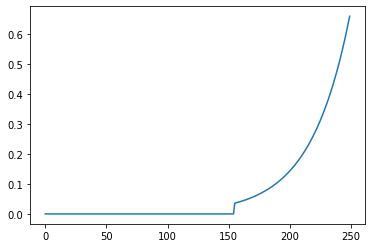

In [96]:
plt.plot(olg.Deficit_ratio[:250])

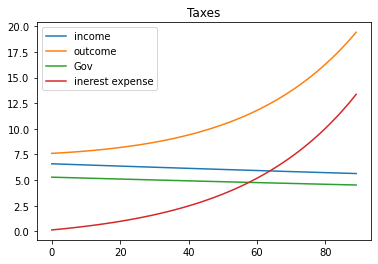

In [100]:
# plt.plot(olg.Gov_Income[200:250])
# Ins_sum  II_sum I_sum VA_sum Pi_sum
plt.plot(olg.Gov_Income[160:250], label = "income")
# plt.plot(olg.Ins_sum[160:250], label = "insurance")
# plt.plot(olg.II_sum[160:250], label = "investment income")
# plt.plot(olg.I_sum[160:250], label = "income")
# plt.plot(olg.VA_sum[160:250], label = "value-added")
# plt.plot(olg.Pi_sum[160:250], label = "profit")
plt.title("Taxes")
plt.plot(olg.Gov_Outcome[160:250], label = "outcome")
plt.plot(olg.Gov[160:250], label = "Gov")
plt.plot(olg.Debt[160:250]*olg.r[160:250]/olg.Gov_Outcome[160:250], label = "inerest expense")
plt.legend()

In [57]:
olg.D

array([0.41758224, 0.41596818, 0.41426401, 0.41272068, 0.4112629 ,
       0.40981745, 0.40833931, 0.40684602, 0.40560088, 0.40452202,
       0.40345835, 0.40234603, 0.4014838 , 0.4008242 , 0.40014054,
       0.39945988, 0.39906161, 0.39852763, 0.39785566, 0.39704744,
       0.39610938, 0.39505   , 0.39388013, 0.39261341, 0.39126531,
       0.38985425, 0.38839877, 0.38691753, 0.38542961, 0.38395262,
       0.38250501, 0.38110322, 0.37976167, 0.37849193, 0.37730103,
       0.37619336, 0.37516912, 0.37422573, 0.37335818, 0.37255919,
       0.37181996, 0.37112947, 0.37047717, 0.36985253, 0.36924542,
       0.3686482 , 0.36805474, 0.36746074, 0.36686333, 0.36626205,
       0.36565884, 0.36505597, 0.36445724, 0.36386741, 0.36329151,
       0.36273477, 0.36220272, 0.36170066, 0.36123211, 0.36080009,
       0.36040674, 0.36005302, 0.35973819, 0.35946071, 0.35921775,
       0.35900566, 0.35881923, 0.35865333, 0.35850207, 0.35835946,
       0.35821974, 0.3580774 , 0.35792756, 0.35776617, 0.35759

In [33]:
olg.Gov

array([2.        , 1.9964958 , 1.99299775, 1.98950582, 1.98602001,
       1.98254031, 1.9790667 , 1.97559918, 1.97213774, 1.96868236,
       1.96523303, 1.96178975, 1.9583525 , 1.95492127, 1.95149606,
       1.94807685, 1.94466362, 1.94125638, 1.93785511, 1.9344598 ,
       1.93107043, 1.92768701, 1.92430951, 1.92093793, 1.91757226,
       1.91421248, 1.91085859, 1.90751058, 1.90416843, 1.90083214,
       1.8975017 , 1.89417709, 1.8908583 , 1.88754533, 1.88423817,
       1.8809368 , 1.87764121, 1.8743514 , 1.87106735, 1.86778906,
       1.86451651, 1.86124969, 1.8579886 , 1.85473322, 1.85148354,
       1.84823956, 1.84500126, 1.84176864, 1.83854168, 1.83532037,
       1.83210471, 1.82889469, 1.82569028, 1.82249149, 1.81929831,
       1.81611072, 1.81292871, 1.80975228, 1.80658142, 1.80341611,
       1.80025635, 1.79710212, 1.79395342, 1.79081024, 1.78767256,
       1.78454039, 1.78141369, 1.77829248, 1.77517674, 1.77206645,
       1.76896162, 1.76586222, 1.76276826, 1.75967972, 1.75659

In [25]:
olg.create_guess()

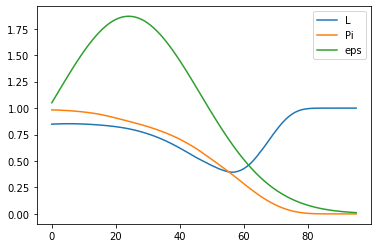

In [607]:
plt.plot(olg.l[0,345:249:-1,250], label = "L")
plt.plot(olg.Pi[0,345:249:-1,250], label = "Pi")
plt.plot(olg.epsilon[0,345:249:-1,250], label ="eps")
plt.legend()

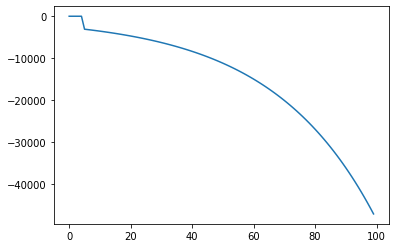

In [509]:
plt.plot(olg.Deficit[150:250])

In [266]:
# dir(olg) I

['A',
 'A_growth',
 'Assets',
 'Consumption',
 'D',
 'Debt',
 'Deficit',
 'Deficit_ratio',
 'G',
 'Gov',
 'Gov_Income',
 'Gov_Outcome',
 'I',
 'II_sum',
 'I_sum',
 'Ins_sum',
 'K',
 'L',
 'L_share',
 'Labor',
 'M',
 'N',
 'N_growth',
 'Pi',
 'Pi_sum',
 'Rho_sum',
 'T',
 'VA_sum',
 'Y',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'a',
 'a_initial',
 'alpha',
 'beta',
 'c',
 'create_guess',
 'delta',
 'epsilon',
 'eta',
 'gamma',
 'household',
 'i',
 'i_steady',
 'k',
 'l',
 'lmbda',
 'lmbda_to_price',
 'lmbda_to_price_steady',
 'omega',
 'phi',
 'price',
 'price_E',
 'price_M',
 'price_N',
 'psi',
 'r',
 'rho',
 'sigma',
 'steady',
 'steady_max_iter',
 'steady_path'

Text(0.5, 1.0, 'wage adjustment')

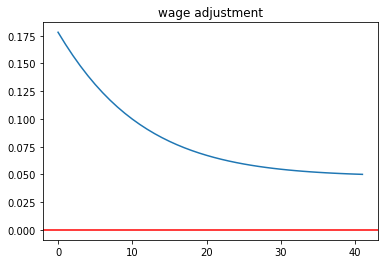

In [173]:
plt.plot([item[1][6] for i, item in enumerate(olg.steady_path)])
# plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.axhline(y=0, color='r', linestyle='-')
plt.title("wage adjustment")

Text(0.5, 1.0, 'Labor')

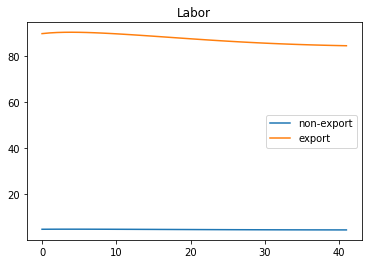

In [174]:
plt.plot([item[1][1]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([(1-item[1][1])*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Labor")

Text(0.5, 1.0, 'Capital')

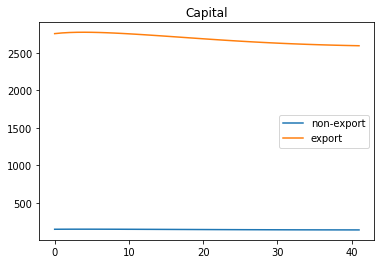

In [175]:
plt.plot([item[1][0]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([item[1][2]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Capital")

Text(0.5, 1.0, 'non-export labor share adjustment')

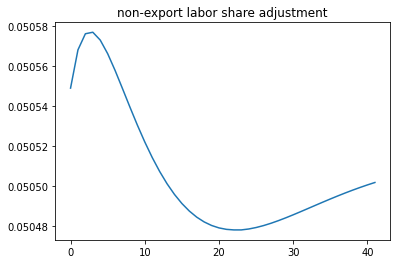

In [176]:
# plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)])
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.title("non-export labor share adjustment")

Text(0.5, 1.0, 'cons adjustment')

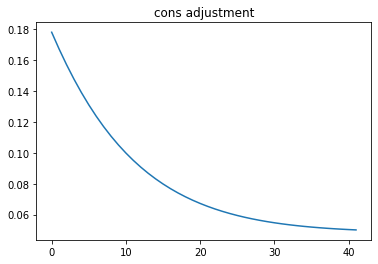

In [177]:
plt.plot([item[1][-3] for i, item in enumerate(olg.steady_path)])
plt.title("cons adjustment")

Text(0.5, 1.0, 'price adjustment')

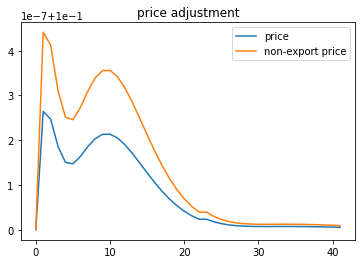

In [178]:
plt.plot([item[1][4] for i, item in enumerate(olg.steady_path)], label ="price")
plt.plot([item[1][5] for i, item in enumerate(olg.steady_path)], label ="non-export price")
plt.legend()
plt.title("price adjustment")

Text(0.5, 1.0, 'Target function')

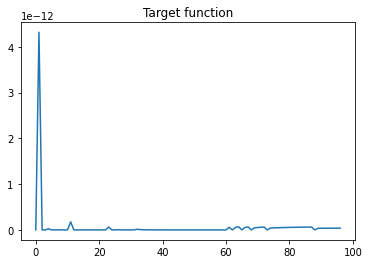

In [163]:
import matplotlib.pyplot as plt
plt.plot([item[0]["fun"] for i, item in enumerate(olg.steady_path)])
plt.title("Target function")

Text(0.5, 1.0, 'k')

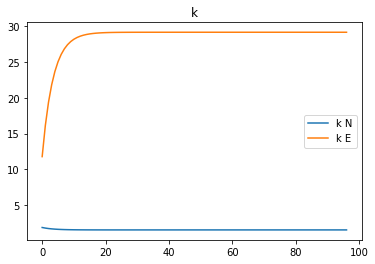

In [164]:
plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)], label ="k N")
plt.plot([item[1][2] for i, item in enumerate(olg.steady_path)], label ="k E")
plt.legend()
plt.title("k")

Text(0.5, 1.0, 'k non-export adjustment')

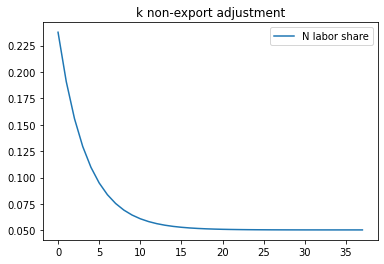

In [152]:
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)], label ="N labor share")
plt.legend()
plt.title("labor share")

In [279]:
olg.steady_path[-4]
# единственный выход это потребление тоже менять с eta

(     fun: 497133.5107400712
     info: {'x': array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]), 'g': array([], dtype=float64), 'obj_val': 497133.5107400712, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': -3, 'status_msg': b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'}
  message: b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'
     nfev: 629
      nit: 21
     njev: 25
   status: -3
  success: False
        x: array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]),
 array

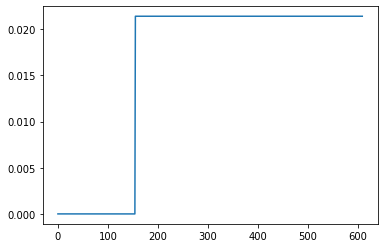

In [38]:
import matplotlib.pyplot as plt
plt.plot(olg.w)

In [39]:
olg.w

array([1.42600744e-05, 1.42507980e-05, 1.42414996e-05, 1.42321791e-05,
       1.42228363e-05, 1.42134710e-05, 1.42040831e-05, 1.41946724e-05,
       1.41852387e-05, 1.41757819e-05, 1.41663018e-05, 1.41567982e-05,
       1.41472709e-05, 1.41377198e-05, 1.41281447e-05, 1.41185453e-05,
       1.41089216e-05, 1.40992733e-05, 1.40896002e-05, 1.40799021e-05,
       1.40701790e-05, 1.40604305e-05, 1.40506564e-05, 1.40408566e-05,
       1.40310309e-05, 1.40211791e-05, 1.40113009e-05, 1.40013962e-05,
       1.39914647e-05, 1.39815062e-05, 1.39715206e-05, 1.39615076e-05,
       1.39514670e-05, 1.39413985e-05, 1.39313020e-05, 1.39211772e-05,
       1.39110239e-05, 1.39008419e-05, 1.38906309e-05, 1.38803907e-05,
       1.38701211e-05, 1.38598218e-05, 1.38494926e-05, 1.38391332e-05,
       1.38287434e-05, 1.38183229e-05, 1.38078715e-05, 1.37973889e-05,
       1.37868749e-05, 1.37763292e-05, 1.37657516e-05, 1.37551417e-05,
       1.37444993e-05, 1.37338241e-05, 1.37231159e-05, 1.37123743e-05,
      

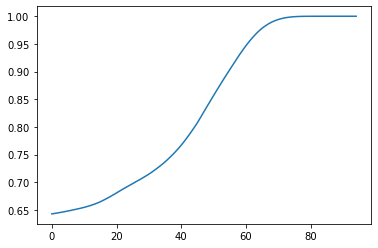

In [606]:
# plt.plot(olg.c[0][345-30,(250-30):(345-30)]) # труд у дрпугих неправильно рассчитывается?
# plt.plot(olg.l[0][345-30,(250-30):(345-30)])


In [43]:
olg.w[99]

1.3201810425347083e-05

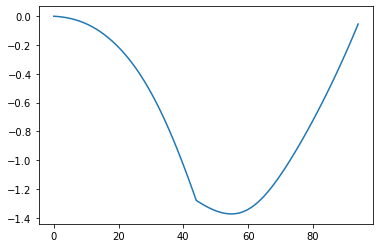

In [25]:
# plt.plot(olg.l[0][260,165:260], label= "labor")
# plt.plot(olg.c[0][260,165:260], label = "consumption")
plt.plot(olg.a[0][260,165:260], label = "assets")
# plt.plot((olg.c[0][260,165:260]**olg.phi * (1-olg.l[0][260,165:260])**(1-olg.phi))**(1-olg.theta)/(1-olg.theta), label = "utility")
plt.show()

Text(0.5, 1.0, 'Wage path')

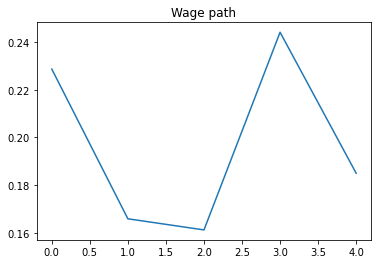

In [614]:
plt.plot([item[0]["info"]["x"][8] for i, item in enumerate(olg.steady_path)if i != 1] [0:])
plt.title("Wage path")

Text(0.5, 1.0, 'Price N path')

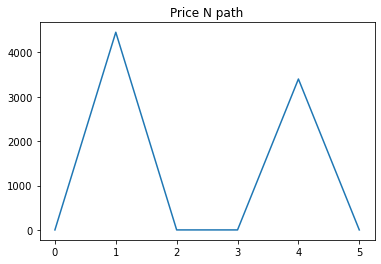

In [615]:
plt.plot([item[0]["info"]["x"][10] for item in olg.steady_path][0:])
plt.title("Price N path")

In [ ]:
import matplotlib.pyplot as plt
# plt.plot((((olg.c[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
# plt.plot((((olg.a[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
plt.plot((((olg.l[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:250])
# plt.plot(olg.I[0,:100]/olg.N[0].sum(axis=0)[:100])
# plt.plot((olg.l[0,:250]*olg.N[0,:250]).sum(axis=0)/(olg.N[0,:250].sum(axis=0)))
plt.show()

In [ ]:
plt.plot(olg.I[0,1:100]/olg.I[0,0:99])

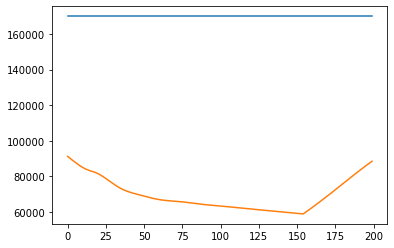

In [616]:
plt.plot(olg.L[0][:200]+olg.L[1][:200])
plt.plot(((olg.l[:,:610,:]*olg.N[:,:610,:]*olg.epsilon[:,:610,:]).sum(axis=0).sum(axis=0))[:200])

In [331]:
olg.L[0][:200]+olg.L[1][:200]

array([170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 1700

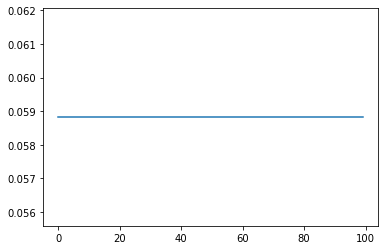

In [332]:
plt.plot((olg.K[0]/olg.L[0])[:100])

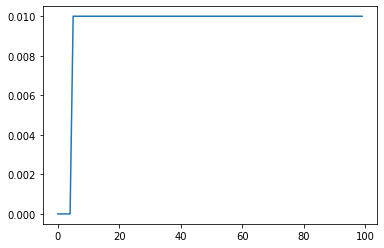

In [44]:
plt.plot(olg.a[0][100][:100])

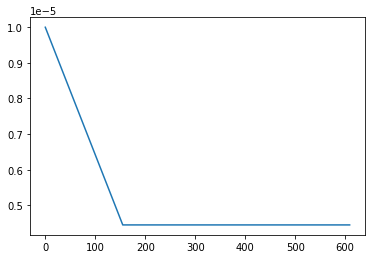

In [45]:
plt.plot(olg.price_N)

In [54]:
olg.w[120]

1.2925927310610548e-05

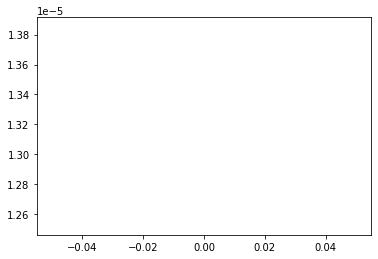

In [49]:
plt.plot(olg.w[100])